Mark's Code

In [3]:
! pip install pyspark -q

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession.builder\
    .appName('MVC_Crahes')\
    .getOrCreate()

In [5]:
# Mount my Google drive and make the .csv file available
# using Google Colab-- I am not sure how accessing these files is going to work for you
# If there is a better way to do this please let me know for the future
#import os
#from google.colab import drive
#if not os.path.exists('/content/drive'):
#    drive.mount('/content/drive')
#    print("Google Drive mounted successfully.")
#else:
#    print("Google Drive is already mounted.")
dataset_file_path = '/content/Motor_Vehicle_Collisions_-_Crashes_20250508.csv'

In [6]:
import time

start_time = time.perf_counter()   # or time.time()

In [7]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("FinalProject").getOrCreate()

# Read the .csv file
df = spark.read.option("header", True).csv(dataset_file_path)

# Show a few rows to confirm
df.show(5)

+----------+----------+-------+--------+---------+---------+--------------------+--------------------+-----------------+---------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+--------------------+--------------------+-------------------+-------------------+-------------------+
|CRASH DATE|CRASH TIME|BOROUGH|ZIP CODE| LATITUDE|LONGITUDE|            LOCATION|      ON STREET NAME|CROSS STREET NAME|OFF STREET NAME|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONTRIBUTING FACTOR VEHICLE 1|CONT

In [8]:
# Print schema to see column names + data types
df.printSchema()

# Total number of records
total_count = df.count()
print(f"Total records: {total_count:,}")


root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: string (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: string (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string (nu

In [9]:
# Create a list of numeric columns

numeric_cols = [
    "NUMBER OF PERSONS INJURED",
    "NUMBER OF PERSONS KILLED",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
    "NUMBER OF MOTORIST INJURED",
    "NUMBER OF MOTORIST KILLED"
]

df.select(numeric_cols).describe().show()

+-------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+
|summary|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|
+-------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+
|  count|                   514908|                  514909|                       514909|                      514909|                   514909|                  514909|                    514909|                   514909|
|   mean|       0.4980986894746246|    0.002720869124447...|          0.08123571349500591|        0.0011

In [10]:
# Count missing values per column

from pyspark.sql.functions import col, sum as _sum, when, isnan

null_counts = df.select([
    _sum(when(col(c).isNull() | isnan(col(c)), 1).otherwise(0)).alias(c)
    for c in df.columns
])

null_counts.show(truncate=False)

+----------+----------+-------+--------+--------+---------+--------+--------------+-----------------+---------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|CRASH DATE|CRASH TIME|BOROUGH|ZIP CODE|LATITUDE|LONGITUDE|LOCATION|ON STREET NAME|CROSS STREET NAME|OFF STREET NAME|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONTRIBUTING FACTOR VEHICLE 1|CONTRIBUTING FACTOR VEHICLE 2|CONTRIBUTING F

In [11]:
# Filter out rows without both LATITUDE and LONGITUDE
from pyspark.sql.functions import col, avg, coalesce

df_filtered = df.filter(
    col("LATITUDE").isNotNull() & col("LONGITUDE").isNotNull()
)

In [12]:
# Imputation strategy
from pyspark.sql.functions import col, avg, coalesce

# Compute avg lat/long per ZIP_CODE
zip_avgs = (
    df.groupBy("ZIP CODE")
      .agg(
          avg(col("LATITUDE")).alias("avg_lat_zip"),
          avg(col("LONGITUDE")).alias("avg_long_zip")
      )
)

# Compute avg lat/long per BOROUGH
borough_avgs = (
    df.groupBy("BOROUGH")
      .agg(
          avg(col("LATITUDE")).alias("avg_lat_borough"),
          avg(col("LONGITUDE")).alias("avg_long_borough")
      )
)

# Join averages back into original dataframe
df_with_avgs = (
    df.join(zip_avgs, on="ZIP CODE", how="left")
      .join(borough_avgs, on="BOROUGH", how="left")
)

# Create new columns that coalesce original value, zip code average and borough average
df_imputed = (
    df_with_avgs
      .withColumn(
          "LATITUDE_NEW",
          coalesce(col("LATITUDE"), col("avg_lat_zip"), col("avg_lat_borough"))
      )
      .withColumn(
          "LONGITUDE_NEW",
          coalesce(col("LONGITUDE"), col("avg_long_zip"), col("avg_long_borough"))
      )
)

# drop helper columns and rename back to LATITUDE/LONGITUDE
df_final = (
    df_imputed
      .drop("LATITUDE", "LONGITUDE",
            "avg_lat_zip", "avg_long_zip",
            "avg_lat_borough", "avg_long_borough")
      .withColumnRenamed("LATITUDE_NEW", "LATITUDE")
      .withColumnRenamed("LONGITUDE_NEW", "LONGITUDE")
)

# Catagorize Data and find how it is distributed

In [13]:
# Frequency by BOROUGH

from pyspark.sql.functions import col, count

df.groupBy("BOROUGH") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10)

df_filtered.groupBy("BOROUGH") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10)

df_final.groupBy("BOROUGH") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10)

+-------------+------+
|      BOROUGH| count|
+-------------+------+
|         NULL|169518|
|     BROOKLYN|119600|
|       QUEENS| 94169|
|        BRONX| 60464|
|    MANHATTAN| 57972|
|STATEN ISLAND| 13186|
+-------------+------+

+-------------+------+
|      BOROUGH| count|
+-------------+------+
|         NULL|136778|
|     BROOKLYN|117261|
|       QUEENS| 92109|
|        BRONX| 58601|
|    MANHATTAN| 56343|
|STATEN ISLAND| 12815|
+-------------+------+

+-------------+------+
|      BOROUGH| count|
+-------------+------+
|         NULL|169518|
|     BROOKLYN|119600|
|       QUEENS| 94169|
|        BRONX| 60464|
|    MANHATTAN| 57972|
|STATEN ISLAND| 13186|
+-------------+------+



In [14]:
# Frequency by ZIP CODE

df.groupBy("ZIP CODE") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10)

df_filtered.groupBy("ZIP CODE") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10)

df_final.groupBy("ZIP CODE") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10)

+--------+------+
|ZIP CODE| count|
+--------+------+
|    NULL|169578|
|   11207|  8685|
|   11236|  5997|
|   11208|  5758|
|   11212|  5748|
|   11203|  5153|
|   11234|  4943|
|   11385|  4882|
|   11226|  4675|
|   11368|  4498|
+--------+------+
only showing top 10 rows

+--------+------+
|ZIP CODE| count|
+--------+------+
|    NULL|136829|
|   11207|  8563|
|   11236|  5919|
|   11208|  5659|
|   11212|  5554|
|   11203|  5095|
|   11234|  4817|
|   11385|  4745|
|   11226|  4601|
|   11368|  4373|
+--------+------+
only showing top 10 rows

+--------+------+
|ZIP CODE| count|
+--------+------+
|    NULL|169578|
|   11207|  8685|
|   11236|  5997|
|   11208|  5758|
|   11212|  5748|
|   11203|  5153|
|   11234|  4943|
|   11385|  4882|
|   11226|  4675|
|   11368|  4498|
+--------+------+
only showing top 10 rows



In [15]:
# Contributing factors broken down by VEHICLE number

df.groupBy("CONTRIBUTING FACTOR VEHICLE 1") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10, truncate=False)

df.groupBy("CONTRIBUTING FACTOR VEHICLE 2") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10, truncate=False)

df.groupBy("CONTRIBUTING FACTOR VEHICLE 3") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10, truncate=False)

df.groupBy("CONTRIBUTING FACTOR VEHICLE 4") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10, truncate=False)

df.groupBy("CONTRIBUTING FACTOR VEHICLE 5") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \
  .show(10, truncate=False)

+------------------------------+------+
|CONTRIBUTING FACTOR VEHICLE 1 |count |
+------------------------------+------+
|Unspecified                   |127826|
|Driver Inattention/Distraction|127207|
|Failure to Yield Right-of-Way |34855 |
|Following Too Closely         |33133 |
|Passing or Lane Usage Improper|21903 |
|Passing Too Closely           |18522 |
|Unsafe Speed                  |17970 |
|Backing Unsafely              |16370 |
|Other Vehicular               |14873 |
|Traffic Control Disregarded   |14053 |
+------------------------------+------+
only showing top 10 rows

+------------------------------+------+
|CONTRIBUTING FACTOR VEHICLE 2 |count |
+------------------------------+------+
|Unspecified                   |336363|
|NULL                          |118099|
|Driver Inattention/Distraction|22555 |
|Following Too Closely         |6007  |
|Other Vehicular               |5870  |
|Passing or Lane Usage Improper|3699  |
|Failure to Yield Right-of-Way |3390  |
|Unsafe Speed 

In [16]:
# Convert CRASH_DATE and CRASH_TIME into a timestamp

from pyspark.sql.functions import col, to_date, to_timestamp, lit, concat

df2 = df.withColumn("CRASH_DATE_DT", to_date(col("CRASH DATE"), "MM/dd/yyyy")) \
        .withColumn(
            "CRASH_TS",
            to_timestamp(
                concat(col("CRASH DATE").cast("string"), lit(" "), col("CRASH TIME")),
                "MM/dd/yyyy HH:mm"
            )
        )

In [17]:
# Find YEAR, MONTH, DAY OF WEEK (DOW), and HOUR
# DAY OF WEEK-- 1=Sunday, 2=Monday, 3=Tuesday, etc...

from pyspark.sql.functions import year, month, dayofweek, hour

df2 = df2.withColumn("CRASH_YEAR", year("CRASH_TS")) \
         .withColumn("CRASH_MONTH", month("CRASH_TS")) \
         .withColumn("CRASH_DOW", dayofweek("CRASH_TS")) \
         .withColumn("CRASH_HOUR", hour("CRASH_TS"))

In [18]:
# Count crashes by CRASH_YEAR
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df2.groupBy("CRASH_YEAR") \
   .agg(count("*").alias("num_crashes")) \
   .orderBy("CRASH_YEAR") \
   .show()

+----------+-----------+
|CRASH_YEAR|num_crashes|
+----------+-----------+
|      2020|     112571|
|      2021|     110557|
|      2022|     103886|
|      2023|      96605|
|      2024|      91290|
+----------+-----------+



In [19]:
# Count crashes by CRASH_MONTH

df2.groupBy("CRASH_MONTH") \
   .agg(count("*").alias("num_crashes")) \
   .orderBy("CRASH_MONTH") \
   .show()


+-----------+-----------+
|CRASH_MONTH|num_crashes|
+-----------+-----------+
|          1|      44659|
|          2|      41796|
|          3|      44242|
|          4|      36367|
|          5|      43101|
|          6|      43892|
|          7|      43901|
|          8|      44279|
|          9|      44524|
|         10|      45386|
|         11|      41808|
|         12|      40954|
+-----------+-----------+



In [20]:
# Count crashes by CRASH_DOW (DAY OF WEEK)
# CRASH_DOW: 1=Sunday, 2=Monday...

df2.groupBy("CRASH_DOW") \
   .agg(count("*").alias("num_crashes")) \
   .orderBy("CRASH_DOW") \
   .show()


+---------+-----------+
|CRASH_DOW|num_crashes|
+---------+-----------+
|        1|      66978|
|        2|      72559|
|        3|      73327|
|        4|      73109|
|        5|      75094|
|        6|      80857|
|        7|      72985|
+---------+-----------+



In [21]:
# Count by CRASH_HOUR

df2.groupBy("CRASH_HOUR") \
   .agg(count("*").alias("num_crashes")) \
   .orderBy("CRASH_HOUR") \
   .show(df2.count(), truncate=False)


+----------+-----------+
|CRASH_HOUR|num_crashes|
+----------+-----------+
|0         |22661      |
|1         |12220      |
|2         |9614       |
|3         |8691       |
|4         |9454       |
|5         |9818       |
|6         |13739      |
|7         |17899      |
|8         |25940      |
|9         |23311      |
|10        |22798      |
|11        |24153      |
|12        |26005      |
|13        |26809      |
|14        |30689      |
|15        |31044      |
|16        |32843      |
|17        |32773      |
|18        |29765      |
|19        |25710      |
|20        |22374      |
|21        |20245      |
|22        |19087      |
|23        |17267      |
+----------+-----------+



In [22]:
# Aggregsate injured and killed by year

from pyspark.sql.types import IntegerType

df2.groupBy("CRASH_YEAR") \
   .agg(
     _sum(col("NUMBER OF PERSONS INJURED").cast(IntegerType())).alias("total_injured"),
     _sum(col("NUMBER OF PERSONS KILLED").cast(IntegerType())).alias("total_killed")
   ) \
   .orderBy("CRASH_YEAR") \
   .show()

+----------+-------------+------------+
|CRASH_YEAR|total_injured|total_killed|
+----------+-------------+------------+
|      2020|        44499|         268|
|      2021|        51784|         297|
|      2022|        51932|         290|
|      2023|        54250|         280|
|      2024|        54010|         266|
+----------+-------------+------------+



In [23]:
# Average injuries and fatalities by CRASH_YEAR

from pyspark.sql.functions import avg
from pyspark.sql.types import DoubleType

df2.groupBy("CRASH_YEAR") \
   .agg(
     avg(col("NUMBER OF PERSONS INJURED").cast(DoubleType())).alias("avg_injured_per_crash"),
     avg(col("NUMBER OF PERSONS KILLED").cast(DoubleType())).alias("avg_killed_per_crash")
   ) \
   .orderBy("CRASH_YEAR") \
   .show()

+----------+---------------------+--------------------+
|CRASH_YEAR|avg_injured_per_crash|avg_killed_per_crash|
+----------+---------------------+--------------------+
|      2020|  0.39529719021772924|0.002380719723552247|
|      2021|   0.4683961069503238|0.002686397062148...|
|      2022|   0.4998941147026548|0.002791521475463489|
|      2023|   0.5615651363801045|0.002898400703897314|
|      2024|   0.5916310658341549|0.002913791214809...|
+----------+---------------------+--------------------+



In [24]:
# Aggregate injuries and deaths by BOROUGH

from pyspark.sql.functions import sum as _sum
from pyspark.sql.types import IntegerType

df2.groupBy("BOROUGH") \
   .agg(
     _sum(col("NUMBER OF PERSONS INJURED").cast(IntegerType())).alias("injured_sum"),
     _sum(col("NUMBER OF PERSONS KILLED").cast(IntegerType())).alias("killed_sum"),
     count("*").alias("collision_count")
   ) \
   .orderBy(col("injured_sum").desc()) \
   .show()

+-------------+-----------+----------+---------------+
|      BOROUGH|injured_sum|killed_sum|collision_count|
+-------------+-----------+----------+---------------+
|         NULL|      95163|       653|         169518|
|     BROOKLYN|      58374|       255|         119600|
|       QUEENS|      43669|       187|          94169|
|        BRONX|      28627|       137|          60464|
|    MANHATTAN|      24719|       131|          57972|
|STATEN ISLAND|       5923|        38|          13186|
+-------------+-----------+----------+---------------+



In [25]:
# Combuned contributing factors across all records

from pyspark.sql.functions import array, explode, col, count

# create one array column containing all five factors
df_factors = df.withColumn(
    "all_factors",
    array(
      "CONTRIBUTING FACTOR VEHICLE 1",
      "CONTRIBUTING FACTOR VEHICLE 2",
      "CONTRIBUTING FACTOR VEHICLE 3",
      "CONTRIBUTING FACTOR VEHICLE 4",
      "CONTRIBUTING FACTOR VEHICLE 5"
    )
)

# explode to get one factor per row
exploded = df_factors.select(explode("all_factors").alias("factor"))

# count non-null, non-empty factors
exploded.filter(col("factor").isNotNull() & (col("factor") != "")) \
         .groupBy("factor") \
         .agg(count("*").alias("count")) \
         .orderBy(col("count").desc()) \
         .show(10, truncate=False)

+------------------------------+------+
|factor                        |count |
+------------------------------+------+
|Unspecified                   |526287|
|Driver Inattention/Distraction|150542|
|Following Too Closely         |40132 |
|Failure to Yield Right-of-Way |38273 |
|Passing or Lane Usage Improper|25662 |
|Other Vehicular               |22143 |
|Unsafe Speed                  |20899 |
|Passing Too Closely           |20835 |
|Backing Unsafely              |17297 |
|Traffic Control Disregarded   |16454 |
+------------------------------+------+
only showing top 10 rows



In [26]:
# If two rows have identical CRASH_DATE, CRASH_TIME, LATITUDE, LONGITUDE,
# and maybe VEHICLE TYPE / REPORT NO, they might be duplicates.

dups = df.groupBy(
    "CRASH DATE", "CRASH TIME", "LATITUDE", "LONGITUDE"
).agg(count("*").alias("dup_count")) \
 .filter(col("dup_count") > 1)

dups.show(10)


+----------+----------+---------+----------+---------+
|CRASH DATE|CRASH TIME| LATITUDE| LONGITUDE|dup_count|
+----------+----------+---------+----------+---------+
| 4/21/2020|     15:00|40.872116| -73.88048|        2|
|  3/3/2020|     22:30|     NULL|      NULL|        2|
| 5/15/2020|     17:00|     NULL|      NULL|        2|
| 5/23/2020|     16:00|     NULL|      NULL|        2|
|11/11/2020|     22:30|     NULL|      NULL|        2|
| 1/16/2021|     22:00| 40.56063|-74.132515|        2|
| 8/16/2021|     13:00|     NULL|      NULL|        2|
| 11/3/2021|     21:36|40.666695|-73.767136|        2|
|  5/1/2022|      4:30|        0|         0|        2|
| 5/17/2022|     19:05|     NULL|      NULL|        2|
+----------+----------+---------+----------+---------+
only showing top 10 rows



In [27]:
# Analize null values by fields

df.filter(col("LATITUDE").isNull() | col("LONGITUDE").isNull()) \
  .count()

df.filter(col("BOROUGH").isNull()).count()


169518

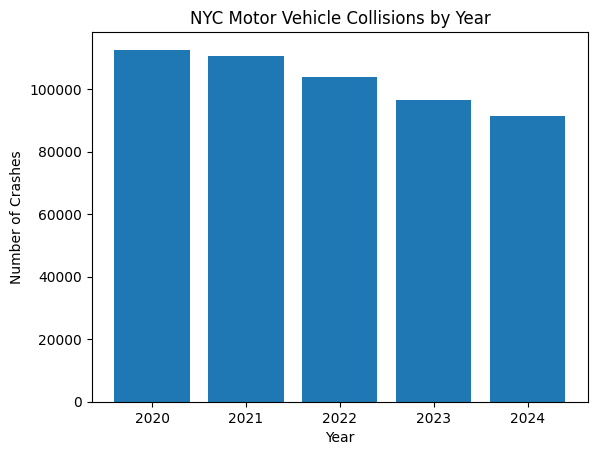

In [28]:
# Bar Chart of crashes per year

import pandas as pd
import matplotlib.pyplot as plt

# Example: crashes by year
year_counts = df2.groupBy("CRASH_YEAR") \
                 .agg(count("*").alias("num_crashes")) \
                 .orderBy("CRASH_YEAR") \
                 .toPandas()

plt.bar(year_counts["CRASH_YEAR"], year_counts["num_crashes"])
plt.xlabel("Year")
plt.ylabel("Number of Crashes")
plt.title("NYC Motor Vehicle Collisions by Year")
plt.show()

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    to_timestamp, concat, lit,
    month, dayofweek, hour,
    when, col
)
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Create Spark session
spark = SparkSession.builder \
    .appName("Collision_Injury_vs_Death_Pipeline") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Create DataFrame
df_proc = (
    df
    # Combine date & time into a timestamp
    .withColumn(
        "CRASH_TS",
        to_timestamp(
            concat(col("CRASH DATE"), lit(" "), col("CRASH TIME")),
            "MM/dd/yyyy HH:mm"
        )
    )
    # Extract time features
    .withColumn("CRASH_MONTH", month("CRASH_TS")) \
    .withColumn("CRASH_DOW",   dayofweek("CRASH_TS")) \
    .withColumn("CRASH_HOUR",  hour("CRASH_TS"))
    # Binary label- injury or death
    .withColumn(
        "any_injury",
        when(
            (col("NUMBER OF PERSONS INJURED") + col("NUMBER OF PERSONS KILLED")) > 0,
            1
        ).otherwise(0)
    )
    # Cast LATITUDE and LONGITUDE
    .withColumn("LATITUDE", col("LATITUDE").cast(DoubleType()))
    .withColumn("LONGITUDE", col("LONGITUDE").cast(DoubleType()))
    # Filter out records missing critical features
    .filter(
        col("CRASH_TS").isNotNull() &
        col("LATITUDE").isNotNull() &
        col("LONGITUDE").isNotNull() &
        col("BOROUGH").isNotNull()
    )
)

# Location Clustering (ZIP‐clusters via lat/long + KMeans)
# Vectorize lat/long
latlong_assembler = VectorAssembler(
    inputCols=["LATITUDE", "LONGITUDE"],
    outputCol="latlong_features"
)
# Cluster into 10 geographic zones
kmeans = KMeans(
    k=10,
    seed=42,
    featuresCol="latlong_features",
    predictionCol="loc_cluster"
)

# Categorical Feature Pipelines
# Borough
borough_idx = StringIndexer(
    inputCol="BOROUGH",
    outputCol="borough_idx",
    handleInvalid="keep"
)
borough_ohe = OneHotEncoder(
    inputCols=["borough_idx"],
    outputCols=["borough_vec"]
)

# ZIP‐cluster from KMeans
cluster_idx = StringIndexer(
    inputCol="loc_cluster",
    outputCol="cluster_idx",
    handleInvalid="keep"
)
cluster_ohe = OneHotEncoder(
    inputCols=["cluster_idx"],
    outputCols=["cluster_vec"]
)

# Primary contributing factor
factor_idx = StringIndexer(
    inputCol="CONTRIBUTING FACTOR VEHICLE 1",
    outputCol="factor_idx",
    handleInvalid="keep"
)
factor_ohe = OneHotEncoder(
    inputCols=["factor_idx"],
    outputCols=["factor_vec"]
)

# Assemble Features
feature_cols = [
    "CRASH_MONTH",
    "CRASH_DOW",
    "CRASH_HOUR",
    "borough_vec",
    "cluster_vec",
    "factor_vec"
]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="any_injury",
    seed=42
)

# Build Pipeline
pipeline = Pipeline(stages=[
    latlong_assembler, kmeans,
    borough_idx, borough_ohe,
    cluster_idx, cluster_ohe,
    factor_idx, factor_ohe,
    assembler,
    rf
])

# train/test split
train_df, test_df = df_proc.randomSplit([0.8, 0.2], seed=42)

# Hyperparameter Tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [5, 10])
    .build()
)

evaluator = MulticlassClassificationEvaluator(
    labelCol="any_injury",
    predictionCol="prediction",
    metricName="accuracy"
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

# Fit & Evaluate


cvModel = cv.fit(train_df)

# Evaluate
predictions = cvModel.transform(test_df)
accuracy   = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy:.4f}")

# inspect confusion matrix / feature importances:
print("Confusion Matrix:")
predictions.groupBy("any_injury", "prediction") \
    .count() \
    .orderBy("any_injury", "prediction") \
    .show()

bestPipelineModel = cvModel.bestModel
rfModel = bestPipelineModel.stages[-1]

# Label feature importances

# Grab the sparse vector of importances
imp = rfModel.featureImportances

# create features column
featurizedDF = bestPipelineModel.transform(train_df).select("features")

# raw metadata dict
meta = featurizedDF.schema["features"].metadata

attrs = []
for attr_list in meta["ml_attr"]["attrs"].values():
    attrs.extend(attr_list)

# featureImportances vector
imp     = rfModel.featureImportances
indices = imp.indices
values  = imp.values

# Build (name, importance) list
feat_imps = [
    (attrs[idx]["name"], val)
    for idx, val in zip(indices, values)
]

# Sort descending by importance
feat_imps_sorted = sorted(feat_imps, key=lambda x: x[1], reverse=True)

# Print
print("Top 10 Feature Importances (desc):")
for name, imp in feat_imps_sorted[:10]:
    print(f"{name:<30} → {imp:.6f}")

# spark.stop()

Test set accuracy = 0.6727
Confusion Matrix:
+----------+----------+-----+
|any_injury|prediction|count|
+----------+----------+-----+
|         0|       0.0|40273|
|         0|       1.0| 2564|
|         1|       0.0|19504|
|         1|       1.0| 5090|
+----------+----------+-----+

Top 10 Feature Importances (desc):
factor_vec_Failure to Yield Right-of-Way → 0.344808
factor_vec_Pedestrian/Bicyclist/Other Pedestrian Error/Confusion → 0.116902
factor_vec_Passing Too Closely → 0.111894
factor_vec_Unspecified         → 0.101072
factor_vec_Traffic Control Disregarded → 0.096284
CRASH_HOUR                     → 0.061014
factor_vec_Backing Unsafely    → 0.045935
CRASH_MONTH                    → 0.039111
factor_vec_Passing or Lane Usage Improper → 0.015018
factor_vec_Lost Consciousness  → 0.014271


In [30]:
# Inspect columns: actual label, predicted label, and probability vector
predictions.select(
    "CRASH_TS",           # timestamp of the crash
    "BOROUGH",            # location
    "any_injury",         # true label (0/1)
    "prediction",         # model 0/1 prediction
    "probability"         # prob of 0, prob of 1
).show(20, truncate=False)

+-------------------+-------------+----------+----------+----------------------------------------+
|CRASH_TS           |BOROUGH      |any_injury|prediction|probability                             |
+-------------------+-------------+----------+----------+----------------------------------------+
|2021-01-01 00:00:00|BROOKLYN     |0         |0.0       |[0.7198671092905151,0.28013289070948494]|
|2021-01-01 00:13:00|BROOKLYN     |1         |0.0       |[0.6809624360337008,0.3190375639662993] |
|2021-01-01 00:30:00|BROOKLYN     |0         |0.0       |[0.6778771352325567,0.32212286476744334]|
|2021-01-01 00:39:00|BROOKLYN     |0         |0.0       |[0.670564910957074,0.329435089042926]   |
|2021-01-01 10:07:00|BRONX        |1         |0.0       |[0.6782597869529091,0.3217402130470909] |
|2021-01-01 10:50:00|QUEENS       |0         |0.0       |[0.678245634571608,0.32175436542839203] |
|2021-01-01 12:00:00|STATEN ISLAND|0         |0.0       |[0.7548973012982495,0.24510269870175055]|
|2021-01-0

Erison' Code

In [31]:
import pandas as pd

raw_df = pd.read_csv('/content/Motor_Vehicle_Collisions_-_Crashes_20250508.csv')

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514909 entries, 0 to 514908
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     514909 non-null  object 
 1   CRASH TIME                     514909 non-null  object 
 2   BOROUGH                        345391 non-null  object 
 3   ZIP CODE                       345331 non-null  float64
 4   LATITUDE                       473907 non-null  float64
 5   LONGITUDE                      473907 non-null  float64
 6   LOCATION                       473907 non-null  object 
 7   ON STREET NAME                 374808 non-null  object 
 8   CROSS STREET NAME              246910 non-null  object 
 9   OFF STREET NAME                140097 non-null  object 
 10  NUMBER OF PERSONS INJURED      514908 non-null  float64
 11  NUMBER OF PERSONS KILLED       514909 non-null  int64  
 12  NUMBER OF PEDESTRIANS INJURED 

In [32]:
# if the column is missing over 70% of the data the loop below will drop that column

missing_threshold = 0.7

for col in raw_df.columns:
    missing_ratio = raw_df[col].isnull().mean()
    if missing_ratio > missing_threshold:
        print(f"Dropping '{col}' - {missing_ratio:.2%} missing")
        raw_df.drop(columns=col, inplace=True)

Dropping 'OFF STREET NAME' - 72.79% missing
Dropping 'CONTRIBUTING FACTOR VEHICLE 3' - 90.48% missing
Dropping 'CONTRIBUTING FACTOR VEHICLE 4' - 97.44% missing
Dropping 'CONTRIBUTING FACTOR VEHICLE 5' - 99.23% missing
Dropping 'VEHICLE TYPE CODE 3' - 91.13% missing
Dropping 'VEHICLE TYPE CODE 4' - 97.57% missing
Dropping 'VEHICLE TYPE CODE 5' - 99.26% missing


In [33]:
# Combine date and time into a single datetime column and Drop original date and time columns

raw_df["CRASH_DATETIME"] = pd.to_datetime(raw_df["CRASH DATE"] + " " + raw_df["CRASH TIME"], errors="coerce")
raw_df.drop(["CRASH DATE", "CRASH TIME"], axis=1, inplace=True)


<ipython-input-34-213458205>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_counts.index, y=na_counts.values, palette='Blues_d')


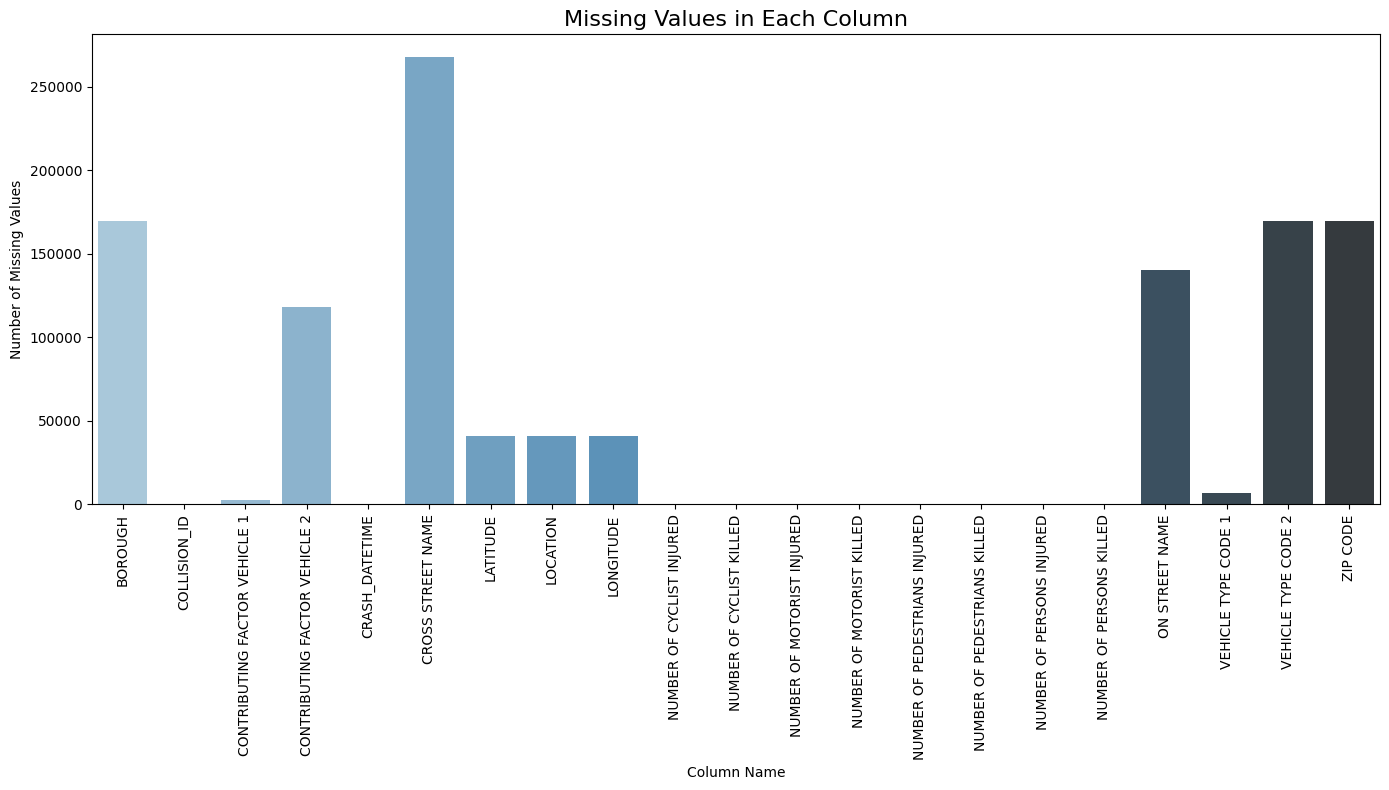

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

na_counts = raw_df.isnull().sum()

na_counts = na_counts.sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=na_counts.index, y=na_counts.values, palette='Blues_d')

# Improve readability
plt.xticks(rotation=90)
plt.title('Missing Values in Each Column', fontsize=16)
plt.ylabel('Number of Missing Values')
plt.xlabel('Column Name')
plt.tight_layout()
plt.show()

In [35]:
raw_df["HAS_INJURY_OR_FATALITY"] = (
    (raw_df["NUMBER OF PERSONS INJURED"] > 0) |
    (raw_df["NUMBER OF PERSONS KILLED"] > 0)
).astype(int)

raw_df = raw_df.dropna(subset=["LATITUDE", "LONGITUDE"])

raw_df["BOROUGH"] = raw_df["BOROUGH"].fillna("UNKNOWN")
raw_df["ZIP CODE"] = raw_df["ZIP CODE"].fillna("00000")

for i in range(1, 2):
    raw_df[f"VEHICLE TYPE CODE {i}"] = raw_df[f"VEHICLE TYPE CODE {i}"].fillna("UNKNOWN")
    raw_df[f"CONTRIBUTING FACTOR VEHICLE {i}"] = raw_df[f"CONTRIBUTING FACTOR VEHICLE {i}"].fillna("Unspecified")

<ipython-input-35-1444896154>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["BOROUGH"] = raw_df["BOROUGH"].fillna("UNKNOWN")


In [36]:
# adding features

raw_df["CRASH_YEAR"] = raw_df["CRASH_DATETIME"].dt.year
raw_df["CRASH_MONTH"] = raw_df["CRASH_DATETIME"].dt.month
raw_df["CRASH_HOUR"] = raw_df["CRASH_DATETIME"].dt.hour
raw_df["CRASH_WEEKDAY"] = raw_df["CRASH_DATETIME"].dt.day_name()

In [37]:
df = raw_df.drop(columns=["LOCATION", "ON STREET NAME", "CROSS STREET NAME"])
df["CRASH_AM_PM"] = df["CRASH_DATETIME"].dt.strftime('%p')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473907 entries, 4 to 514908
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   BOROUGH                        473907 non-null  object        
 1   ZIP CODE                       473907 non-null  object        
 2   LATITUDE                       473907 non-null  float64       
 3   LONGITUDE                      473907 non-null  float64       
 4   NUMBER OF PERSONS INJURED      473906 non-null  float64       
 5   NUMBER OF PERSONS KILLED       473907 non-null  int64         
 6   NUMBER OF PEDESTRIANS INJURED  473907 non-null  int64         
 7   NUMBER OF PEDESTRIANS KILLED   473907 non-null  int64         
 8   NUMBER OF CYCLIST INJURED      473907 non-null  int64         
 9   NUMBER OF CYCLIST KILLED       473907 non-null  int64         
 10  NUMBER OF MOTORIST INJURED     473907 non-null  int64         
 11  NUMBE

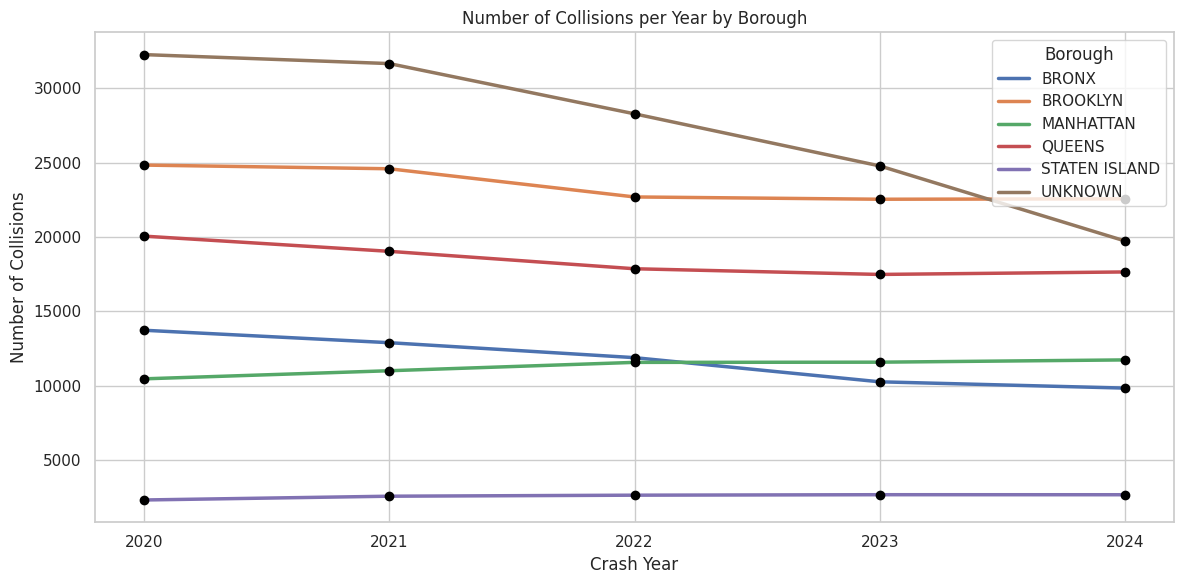

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the grouped data
collisions_by_year_borough = df.groupby(["CRASH_YEAR", "BOROUGH"]).size().reset_index(name="COUNT")

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Draw colored lines without markers
sns.lineplot(
    data=collisions_by_year_borough,
    x="CRASH_YEAR",
    y="COUNT",
    hue="BOROUGH",
    linewidth=2.5,
    legend=True
)

# Overlay black dots manually
for borough in collisions_by_year_borough["BOROUGH"].unique():
    borough_data = collisions_by_year_borough[collisions_by_year_borough["BOROUGH"] == borough]
    plt.plot(
        borough_data["CRASH_YEAR"],
        borough_data["COUNT"],
        'o',
        color='black',
        markersize=6
    )

plt.title("Number of Collisions per Year by Borough")
plt.xlabel("Crash Year")
plt.ylabel("Number of Collisions")

years = sorted(df["CRASH_YEAR"].unique())
plt.xticks(ticks=years)

plt.legend(title="Borough")
plt.tight_layout()
plt.show()

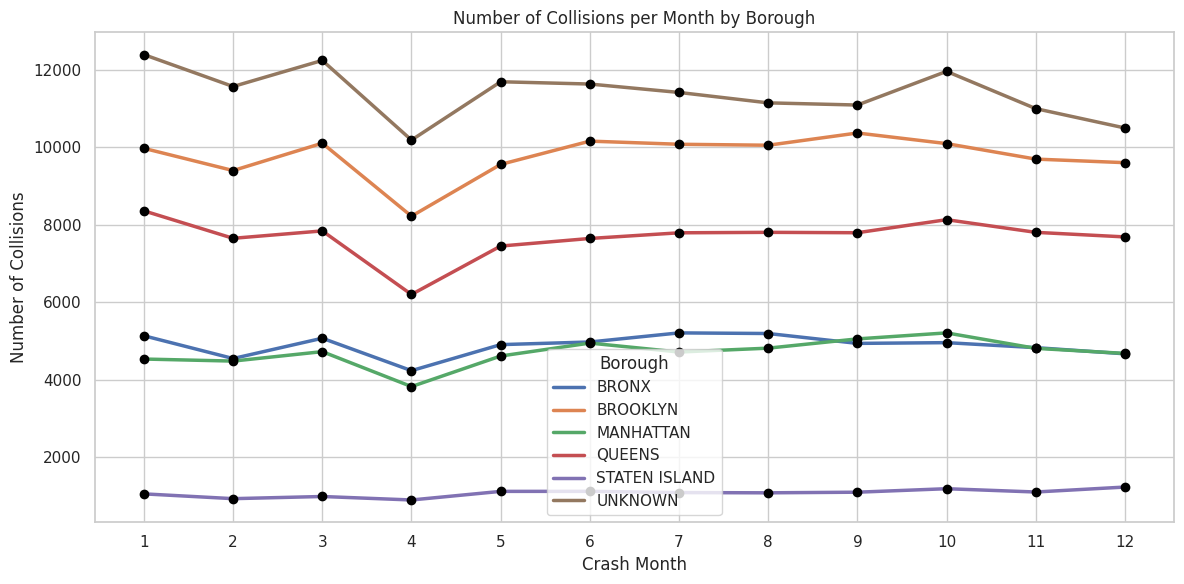

In [40]:
monthly_collisions = df.groupby(["CRASH_MONTH", "BOROUGH"]).size().reset_index(name="COUNT")

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.lineplot(
    data=monthly_collisions,
    x="CRASH_MONTH",
    y="COUNT",
    hue="BOROUGH",
    linewidth=2.5
)

for borough in monthly_collisions["BOROUGH"].unique():
    borough_data = monthly_collisions[monthly_collisions["BOROUGH"] == borough]
    plt.plot(
        borough_data["CRASH_MONTH"],
        borough_data["COUNT"],
        'o',
        color='black',
        markersize=6)

plt.title("Number of Collisions per Month by Borough")
plt.xlabel("Crash Month")
plt.ylabel("Number of Collisions")
plt.xticks(range(1, 13))
plt.legend(title="Borough")
plt.tight_layout()
plt.show()

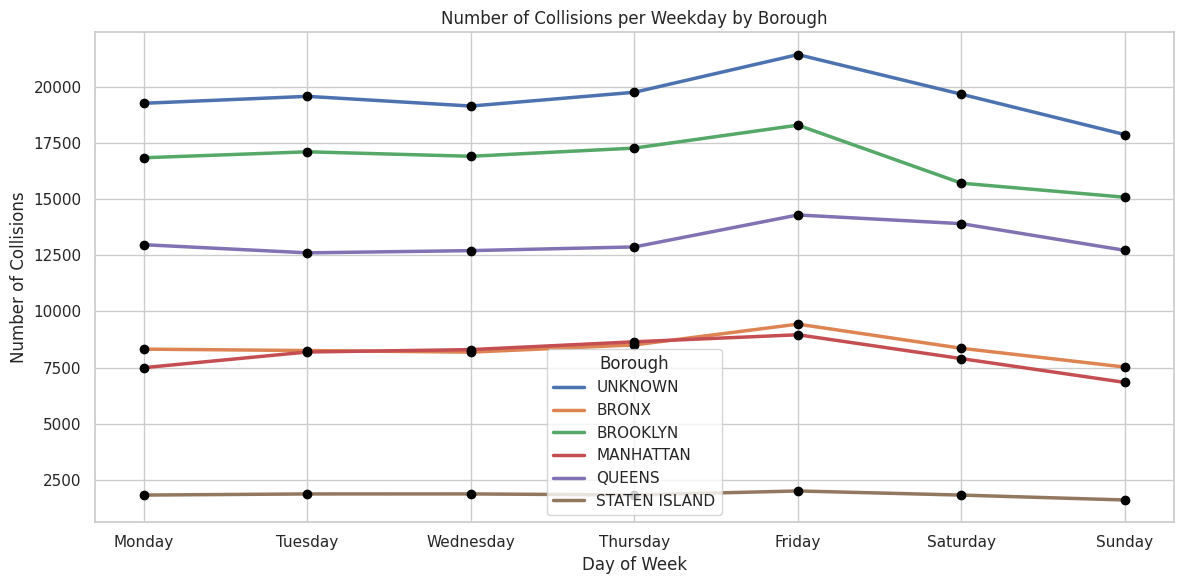

In [41]:
# Optional: enforce weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group and count
weekly_collisions = df.groupby(["CRASH_WEEKDAY", "BOROUGH"]).size().reset_index(name="COUNT")
weekly_collisions["CRASH_WEEKDAY"] = pd.Categorical(
    weekly_collisions["CRASH_WEEKDAY"],
    categories=weekday_order,
    ordered=True
)
weekly_collisions.sort_values("CRASH_WEEKDAY", inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.lineplot(
    data=weekly_collisions,
    x="CRASH_WEEKDAY",
    y="COUNT",
    hue="BOROUGH",
    linewidth=2.5
)

# Black markers
for borough in weekly_collisions["BOROUGH"].unique():
    borough_data = weekly_collisions[weekly_collisions["BOROUGH"] == borough]
    plt.plot(
        borough_data["CRASH_WEEKDAY"],
        borough_data["COUNT"],
        'o',
        color='black',
        markersize=6
    )

# Customize
plt.title("Number of Collisions per Weekday by Borough")
plt.xlabel("Day of Week")
plt.ylabel("Number of Collisions")
plt.legend(title="Borough")
plt.tight_layout()
plt.show()

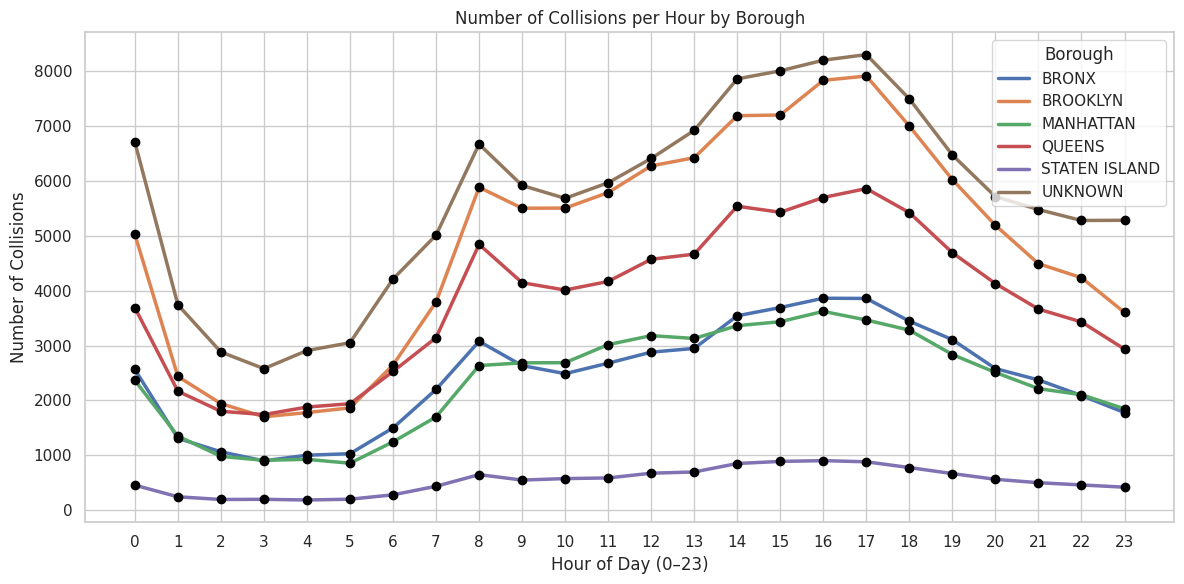

In [42]:
# Group and count by hour and borough
hourly_collisions = df.groupby(["CRASH_HOUR", "BOROUGH"]).size().reset_index(name="COUNT")

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Line plot for hourly collisions
sns.lineplot(
    data=hourly_collisions,
    x="CRASH_HOUR",
    y="COUNT",
    hue="BOROUGH",
    linewidth=2.5
)

# Add black dots on top
for borough in hourly_collisions["BOROUGH"].unique():
    borough_data = hourly_collisions[hourly_collisions["BOROUGH"] == borough]
    plt.plot(
        borough_data["CRASH_HOUR"],
        borough_data["COUNT"],
        'o',
        color='black',
        markersize=6
    )

# Customize
plt.title("Number of Collisions per Hour by Borough")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Collisions")
plt.xticks(range(0, 24))
plt.legend(title="Borough")
plt.tight_layout()
plt.show()

In [43]:
borough_dummies = pd.get_dummies(df['BOROUGH'], prefix='BOROUGH')
df = pd.concat([df, borough_dummies], axis=1)

In [44]:
cols_to_drop = [
    'NUMBER OF PERSONS INJURED',
    'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED',
    'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED',
    'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED',
    'NUMBER OF MOTORIST KILLED'
]

df = df.drop(columns=cols_to_drop)

In [45]:
weekday_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

df['CRASH_WEEKDAY'] = df['CRASH_WEEKDAY'].map(weekday_mapping)

ampm_mapping = {
    'AM': 0,
    'PM': 1
}

df['CRASH_AM_PM'] = df['CRASH_AM_PM'].map(ampm_mapping)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473907 entries, 4 to 514908
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   BOROUGH                        473907 non-null  object        
 1   ZIP CODE                       473907 non-null  object        
 2   LATITUDE                       473907 non-null  float64       
 3   LONGITUDE                      473907 non-null  float64       
 4   CONTRIBUTING FACTOR VEHICLE 1  473907 non-null  object        
 5   CONTRIBUTING FACTOR VEHICLE 2  364531 non-null  object        
 6   COLLISION_ID                   473907 non-null  int64         
 7   VEHICLE TYPE CODE 1            473907 non-null  object        
 8   VEHICLE TYPE CODE 2            316325 non-null  object        
 9   CRASH_DATETIME                 473907 non-null  datetime64[ns]
 10  HAS_INJURY_OR_FATALITY         473907 non-null  int64         
 11  CRASH

In [47]:
df_timeseries = df[[
    'CRASH_DATETIME',
    'CRASH_YEAR',
    'CRASH_MONTH',
    'CRASH_HOUR',
    'CRASH_WEEKDAY',
    'CRASH_AM_PM',
    'HAS_INJURY_OR_FATALITY'
]].copy()


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X = df_timeseries.drop(columns=['CRASH_DATETIME', 'HAS_INJURY_OR_FATALITY'])
y = df_timeseries['HAS_INJURY_OR_FATALITY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.64      0.90      0.74     59520
           1       0.45      0.14      0.22     35262

    accuracy                           0.62     94782
   macro avg       0.54      0.52      0.48     94782
weighted avg       0.57      0.62      0.55     94782



In [50]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59     59520
           1       0.42      0.57      0.48     35262

    accuracy                           0.54     94782
   macro avg       0.55      0.55      0.54     94782
weighted avg       0.58      0.54      0.55     94782



<ipython-input-51-4060490058>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


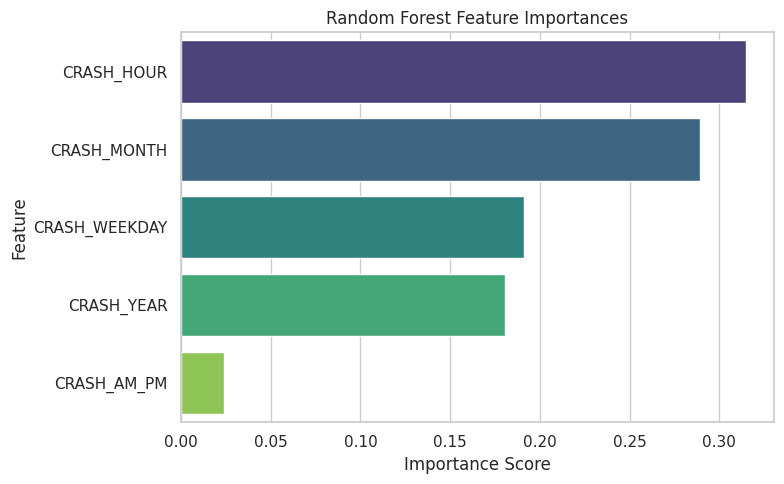

In [51]:
importances = rf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

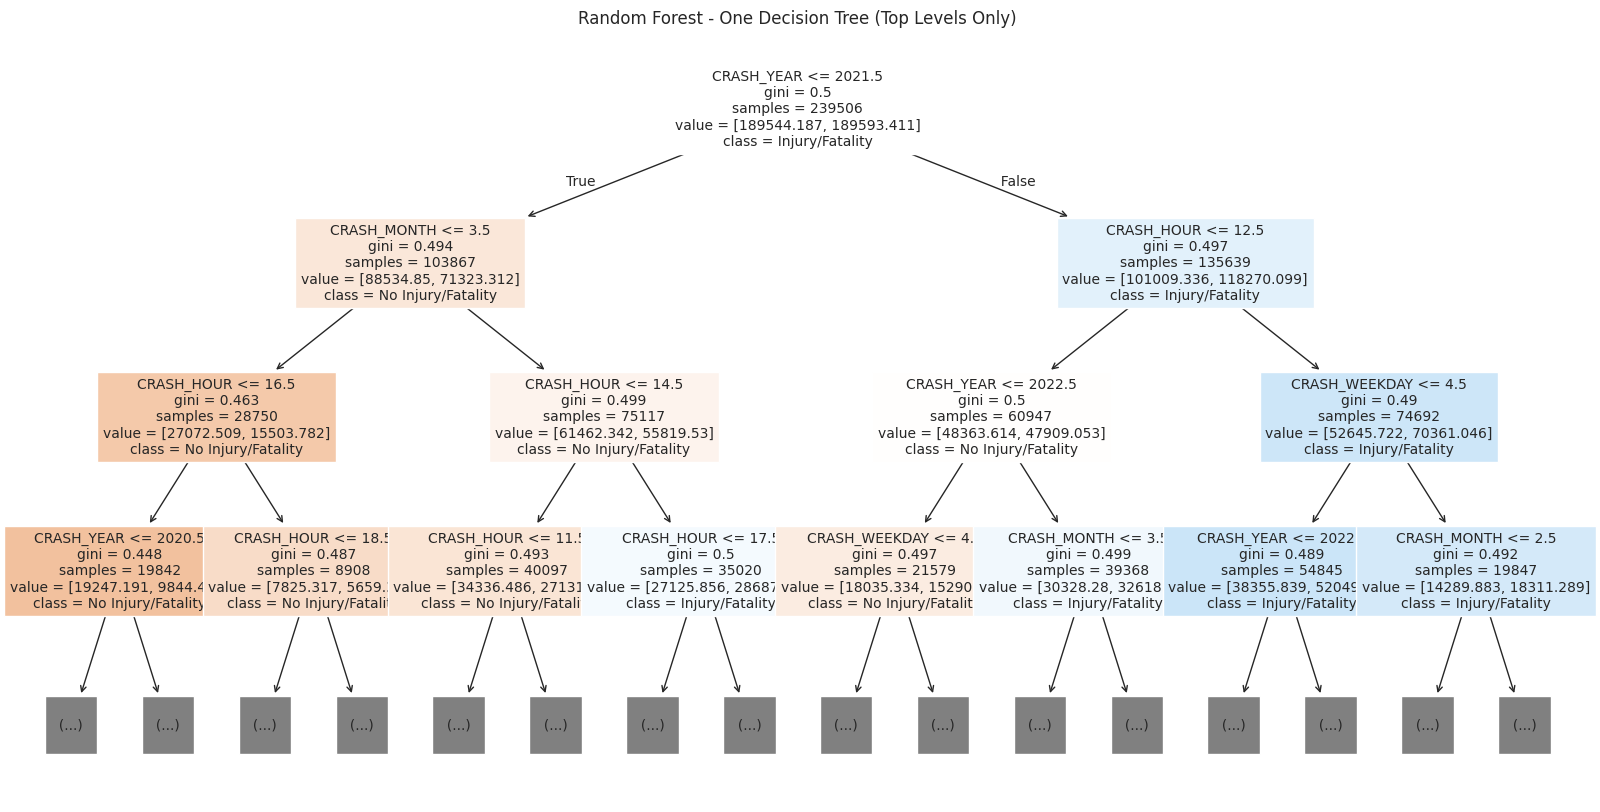

In [52]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

one_tree = rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(
    one_tree,
    feature_names=X.columns,
    class_names=['No Injury/Fatality', 'Injury/Fatality'],
    filled=True,
    max_depth=3,  # show only top 3 levels for clarity
    fontsize=10
)
plt.title("Random Forest - One Decision Tree (Top Levels Only)")
plt.show()

Joshua's Code

In [54]:
import pandas as pd

raw_df = pd.read_csv('/content/Motor_Vehicle_Collisions_-_Crashes_20250508.csv')

In [55]:
# if the column is missing over 70% of the data the loop below will drop that column

missing_threshold = 0.7

for col in raw_df.columns:
    missing_ratio = raw_df[col].isnull().mean()
    if missing_ratio > missing_threshold:
        print(f"Dropping '{col}' - {missing_ratio:.2%} missing")
        raw_df.drop(columns=col, inplace=True)

Dropping 'OFF STREET NAME' - 72.79% missing
Dropping 'CONTRIBUTING FACTOR VEHICLE 3' - 90.48% missing
Dropping 'CONTRIBUTING FACTOR VEHICLE 4' - 97.44% missing
Dropping 'CONTRIBUTING FACTOR VEHICLE 5' - 99.23% missing
Dropping 'VEHICLE TYPE CODE 3' - 91.13% missing
Dropping 'VEHICLE TYPE CODE 4' - 97.57% missing
Dropping 'VEHICLE TYPE CODE 5' - 99.26% missing


In [56]:
# Combine date and time into a single datetime column and Drop original date and time columns

raw_df["CRASH_DATETIME"] = pd.to_datetime(raw_df["CRASH DATE"] + " " + raw_df["CRASH TIME"], errors="coerce")
raw_df.drop(["CRASH DATE", "CRASH TIME"], axis=1, inplace=True)


In [57]:
raw_df["HAS_INJURY_OR_FATALITY"] = (
    (raw_df["NUMBER OF PERSONS INJURED"] > 0) |
    (raw_df["NUMBER OF PERSONS KILLED"] > 0)
).astype(int)

raw_df = raw_df.dropna(subset=["LATITUDE", "LONGITUDE"])

raw_df["BOROUGH"] = raw_df["BOROUGH"].fillna("UNKNOWN")
raw_df["ZIP CODE"] = raw_df["ZIP CODE"].fillna("00000")

for i in range(1, 2):
    raw_df[f"VEHICLE TYPE CODE {i}"] = raw_df[f"VEHICLE TYPE CODE {i}"].fillna("UNKNOWN")
    raw_df[f"CONTRIBUTING FACTOR VEHICLE {i}"] = raw_df[f"CONTRIBUTING FACTOR VEHICLE {i}"].fillna("Unspecified")

<ipython-input-57-1444896154>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["BOROUGH"] = raw_df["BOROUGH"].fillna("UNKNOWN")


In [58]:
# adding features

raw_df["CRASH_YEAR"] = raw_df["CRASH_DATETIME"].dt.year
raw_df["CRASH_MONTH"] = raw_df["CRASH_DATETIME"].dt.month
raw_df["CRASH_HOUR"] = raw_df["CRASH_DATETIME"].dt.hour
raw_df["CRASH_WEEKDAY"] = raw_df["CRASH_DATETIME"].dt.day_name()

In [59]:
df = raw_df.drop(columns=["LOCATION", "ON STREET NAME", "CROSS STREET NAME"])

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473907 entries, 4 to 514908
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   BOROUGH                        473907 non-null  object        
 1   ZIP CODE                       473907 non-null  object        
 2   LATITUDE                       473907 non-null  float64       
 3   LONGITUDE                      473907 non-null  float64       
 4   NUMBER OF PERSONS INJURED      473906 non-null  float64       
 5   NUMBER OF PERSONS KILLED       473907 non-null  int64         
 6   NUMBER OF PEDESTRIANS INJURED  473907 non-null  int64         
 7   NUMBER OF PEDESTRIANS KILLED   473907 non-null  int64         
 8   NUMBER OF CYCLIST INJURED      473907 non-null  int64         
 9   NUMBER OF CYCLIST KILLED       473907 non-null  int64         
 10  NUMBER OF MOTORIST INJURED     473907 non-null  int64         
 11  NUMBE

In [61]:
df["CRASH_AM_PM"] = df["CRASH_DATETIME"].dt.strftime('%p')

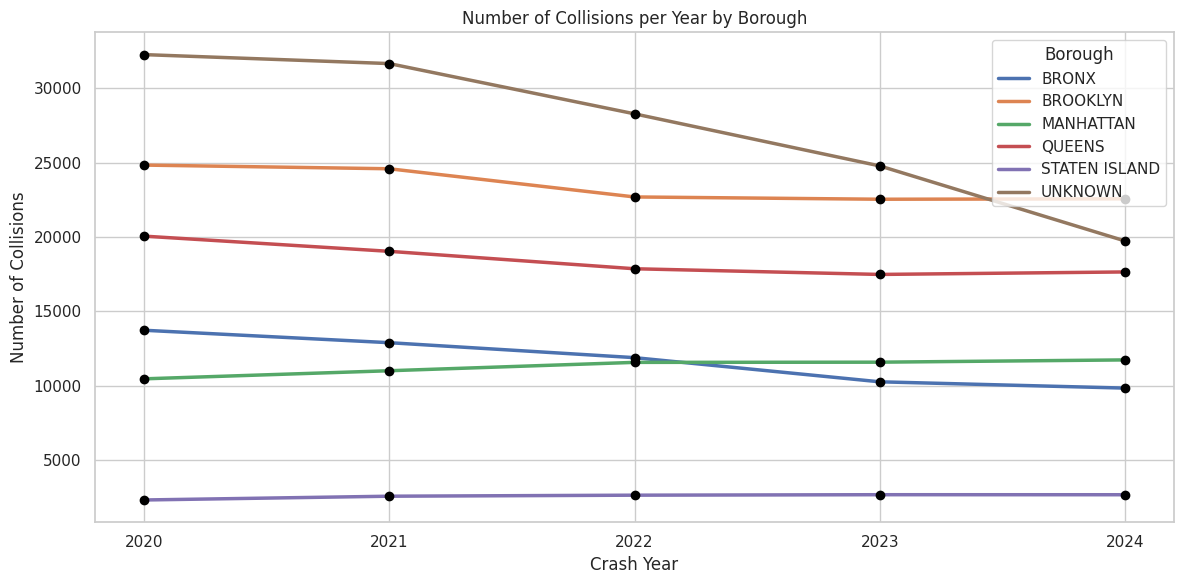

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the grouped data
collisions_by_year_borough = df.groupby(["CRASH_YEAR", "BOROUGH"]).size().reset_index(name="COUNT")

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Draw colored lines without markers
sns.lineplot(
    data=collisions_by_year_borough,
    x="CRASH_YEAR",
    y="COUNT",
    hue="BOROUGH",
    linewidth=2.5,
    legend=True
)

# Overlay black dots manually
for borough in collisions_by_year_borough["BOROUGH"].unique():
    borough_data = collisions_by_year_borough[collisions_by_year_borough["BOROUGH"] == borough]
    plt.plot(
        borough_data["CRASH_YEAR"],
        borough_data["COUNT"],
        'o',
        color='black',
        markersize=6
    )

plt.title("Number of Collisions per Year by Borough")
plt.xlabel("Crash Year")
plt.ylabel("Number of Collisions")

years = sorted(df["CRASH_YEAR"].unique())
plt.xticks(ticks=years)

plt.legend(title="Borough")
plt.tight_layout()
plt.show()

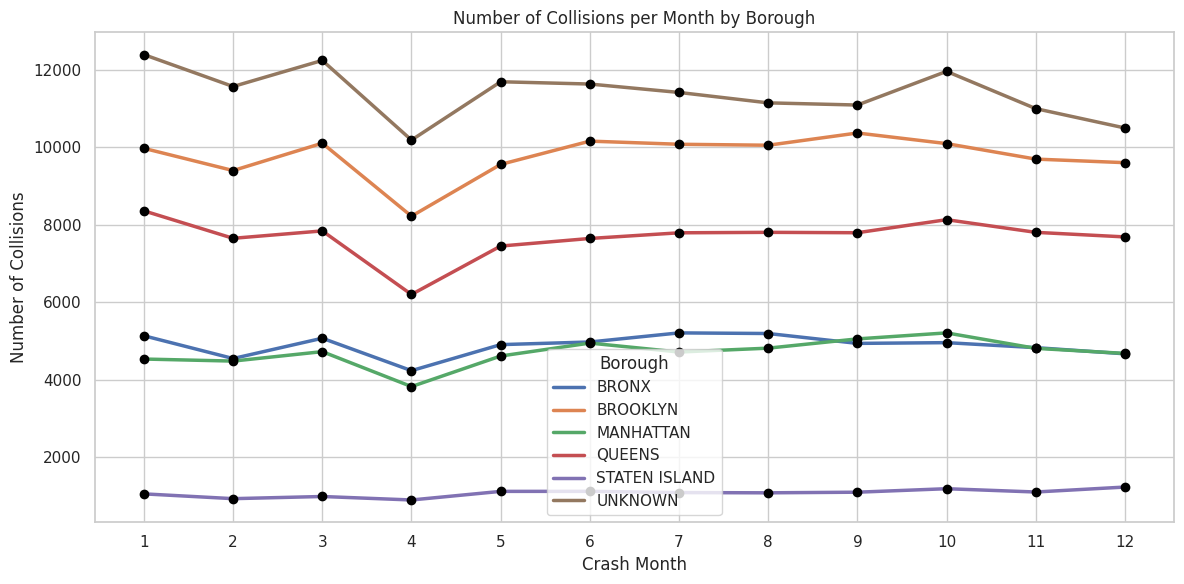

In [63]:
monthly_collisions = df.groupby(["CRASH_MONTH", "BOROUGH"]).size().reset_index(name="COUNT")

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.lineplot(
    data=monthly_collisions,
    x="CRASH_MONTH",
    y="COUNT",
    hue="BOROUGH",
    linewidth=2.5
)

for borough in monthly_collisions["BOROUGH"].unique():
    borough_data = monthly_collisions[monthly_collisions["BOROUGH"] == borough]
    plt.plot(
        borough_data["CRASH_MONTH"],
        borough_data["COUNT"],
        'o',
        color='black',
        markersize=6)

plt.title("Number of Collisions per Month by Borough")
plt.xlabel("Crash Month")
plt.ylabel("Number of Collisions")
plt.xticks(range(1, 13))
plt.legend(title="Borough")
plt.tight_layout()
plt.show()

In [64]:
# feature engineering
df_log = df.copy()

# create a spark dataframe of df_log
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CollisionAnalysis").getOrCreate()

df_log = spark.createDataFrame(df_log)

# create binary classification for number of persons injured if greater than equal to equals 1 else 0
df_log = df_log.withColumn("PERSON_INJURED", (df_log["NUMBER OF PERSONS INJURED"] >= 1).cast("integer"))

# create binary classification for number of persons killed if greater than equal to equals 1 else 0
df_log = df_log.withColumn("PERSON_KILLED", (df_log["NUMBER OF PERSONS KILLED"] >= 1).cast("integer"))

df_log.show()


+-------------+--------+---------+----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+------------+--------------------+--------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+
|      BOROUGH|ZIP CODE| LATITUDE| LONGITUDE|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONTRIBUTING FACTOR VEHICLE 1|CONTRIBUTING FACTOR VEHICLE 2|COLLISION_ID| VEHICLE TYPE CODE 1| VEHICLE TYPE CODE 2|     CRASH_DATETIME|HAS_INJURY_OR_FATALITY|CRASH_YEAR|CRASH_MONTH|CRASH_HOUR|CRASH_WEEKDAY|CRASH_AM_PM|PERSON_INJURED|P

In [65]:
# remove UNKNOWN from BOROUGHS
df_log = df_log.filter(df_log["BOROUGH"] != "UNKNOWN")

# remove Unspecified from CONTRIBUTING FACTORS VEHICLE 1
df_log = df_log.filter(df_log["CONTRIBUTING FACTOR VEHICLE 1"] != "Unspecified")

# remove NaN values from CONTRIBUTNIG FACTORS VEHICLE 1
df_log = df_log.filter(df_log["CONTRIBUTING FACTOR VEHICLE 1"].isNotNull())

# change CRASH_MONTH to string month
from pyspark.sql.functions import date_format
df_log = df_log.withColumn("CRASH_MONTH", date_format(df_log["CRASH_DATETIME"], "MMMM"))

In [66]:
# create list for like categories in CONTRIBUTING FACTORS VEHICLE 1
'''
Driver Behavior =
Aggressive Driving/Road Rage
Backing Unsafely
Driver Inattention/Distraction
Driver Inexperience
Eating or Drinking
Failure to Keep Right
Failure to Yield Right-of-Way
Fatigued/Drowsy
Fell Asleep
Following Too Closely
Listening/Using Headphones
Outside Car Distraction
Passenger Distraction
Passing or Lane Usage Improper
Passing Too Closely
Reaction to Uninvolved Vehicle
Turning Improperly
Unsafe Lane Changing
Unsafe Speed'''
driver_behavior = ["Aggressive Driving/Road Rage", "Backing Unsafely", "Driver Inattention/Distraction", "Driver Inexperience", "Eating or Drinking",
                   "Failure to Keep Right", "Failure to Yield Right-of-Way", "Fatigued/Drowsy", "Fell Asleep", "Following Too Closely",
                   "Listening/Using Headphones", "Outside Car Distraction", "Passenger Distraction", "Passing or Lane Usage Improper",
                   "Passing Too Closely","Reaction to Uninvolved Vehicle", "Turning Improperly", "Unsafe Lane Changing", "Unsafe Speed"]
'''
Impairment (Substance or Health Related) =
Alcohol Involvement
Drugs (illegal)
Prescription Medication
Physical Disability
Illness
Lost Consciousness
'''
driver_impairment = ["Alcohol Involvement", "Drugs (illegal)", "Prescription Medication", "Physical Disability", "Illness", "Lost Consciousness"]

'''
Distraction (Technology Related) =
Cell Phone (hand-Held)
Cell Phone (hands-free)
Other Electronic Device
Texting
Using On Board Navigation Device
'''
driver_distraction = ["Cell Phone (hand-Held)", "Cell Phone (hands-free)", "Other Electronic Device", "Texting", "Using On Board Navigation Device"]

'''
Vehicle Defects =
Accelerator Defective
Brakes Defective
Headlights Defective
Other Lighting Defects
Steering Failure
Tire Failure/Inadequate
Tow Hitch Defective
Windshield Inadequate
Tinted Windows
Other Vehicular
'''
vehicle_defects = ["Accelerator Defective", "Brakes Defective", "Headlights Defective", "Other Lighting Defects", "Steering Failure",
                   "Tire Failure/Inadequate", "Tow Hitch Defective", "Windshield Inadequate", "Tinted Windows", "Other Vehicular"]
'''
Road/Environmental Conditions =
Animals Action
Glare
Obstruction/Debris
Pavement Defective
Pavement Slippery
Shoulders Defective/Improper
View Obstructed/Limited
Lane Marking Improper/Inadequate
'''
re_conditions = ["Road/Environmental Conditions", "Animals Action", "Glare", "Obstruction/Debris", "Pavement Defective",
                 "Pavement Slippery", "Shoulders Defective/Improper", "View Obstructed/Limited", "Lane Marking Improper/Inadequate"]
'''
Traffic Control Issues =
Traffic Control Device Improper/Non-Working
Traffic Control Disregarded
'''
traffic_control = ["Traffic Control Issues", "Traffic Control Device Improper/Non-Working", "Traffic Control Disregarded"]

'''
Pedestrian/Cyclist Factors =
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion
'''
pedestrian_factors = ["Pedestrian/Bicyclist/Other Pedestrian Error/Confusion"]

'''
Vehicle Status =
Driverless/Runaway Vehicle
Oversized Vehicle
Vehicle Vandalism
'''
vehicle_status = ["Driverless/Runaway Vehicle", "Oversized Vehicle", "Vehicle Vandalism"]

In [67]:
# create a column called MODIFIED FACTORS baseon the list categories
from pyspark.sql.functions import when, col
df_log = df_log.withColumn("MODIFIED_FACTORS",
                           when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(driver_behavior), "Driver Behavior")
                           .when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(driver_impairment), "Driver Impairment")
                           .when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(driver_distraction), "Driver Distractions")
                           .when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(vehicle_defects), "Vehicle Defects")
                           .when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(re_conditions), "Road/Environmental Conditions")
                           .when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(traffic_control), "Traffic Control Issues")
                           .when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(pedestrian_factors), "Pedestrian/Cyclist Factors")
                           .when(col('CONTRIBUTING FACTOR VEHICLE 1').isin(vehicle_status), "Vehicle Status"))

In [68]:
df_log.show()

+-------------+--------+---------+----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+------------+--------------------+--------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+----------------+
|      BOROUGH|ZIP CODE| LATITUDE| LONGITUDE|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONTRIBUTING FACTOR VEHICLE 1|CONTRIBUTING FACTOR VEHICLE 2|COLLISION_ID| VEHICLE TYPE CODE 1| VEHICLE TYPE CODE 2|     CRASH_DATETIME|HAS_INJURY_OR_FATALITY|CRASH_YEAR|CRASH_MONTH|CRASH_HOUR|CRASH_WEEKDAY|CRASH_AM_PM

In [69]:
df_log.printSchema()

root
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NUMBER OF PERSONS INJURED: double (nullable = true)
 |-- NUMBER OF PERSONS KILLED: long (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: long (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: long (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: long (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: long (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: long (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: long (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string (nullable = true)
 |-- COLLISION_ID: long (nullable = true)
 |-- VEHICLE TYPE CODE 1: string (nullable = true)
 |-- VEHICLE TYPE CODE 2: string (nullable = true)
 |-- CRASH_DATETIME: timestamp (nullable = true)
 |-- HAS_INJURY_OR_FATALITY: long (nullable = true)
 |-- CRASH_YEAR: lon

In [70]:
# one hot encoding for BOROUGH, CRASH_MONTH, CRASH_WEEKDAY, CRASH_AM_PM, MODIFIED FACTORS
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# String Indexing
indexerB = StringIndexer(inputCol='BOROUGH', outputCol='BOROUGH_indexed', handleInvalid='skip')
indexerM = StringIndexer(inputCol='CRASH_MONTH', outputCol='CRASH_MONTH_indexed', handleInvalid='skip')
indexerW = StringIndexer(inputCol='CRASH_WEEKDAY', outputCol='CRASH_WEEKDAY_indexed', handleInvalid='skip')
indexerA = StringIndexer(inputCol='CRASH_AM_PM', outputCol='CRASH_AM_PM_indexed', handleInvalid='skip')
indexerF = StringIndexer(inputCol='MODIFIED_FACTORS', outputCol='MODIFIED_FACTORS_indexed', handleInvalid='skip')

# Fit and transform with StringIndexers
df_log = indexerB.fit(df_log).transform(df_log)
df_log = indexerM.fit(df_log).transform(df_log)
df_log = indexerW.fit(df_log).transform(df_log)
df_log = indexerA.fit(df_log).transform(df_log)
df_log = indexerF.fit(df_log).transform(df_log)

# One Hot Encoding
oheB = OneHotEncoder(inputCol='BOROUGH_indexed', outputCol='BOROUGH_ohe')
oheM = OneHotEncoder(inputCol='CRASH_MONTH_indexed', outputCol='CRASH_MONTH_ohe')
oheW = OneHotEncoder(inputCol='CRASH_WEEKDAY_indexed', outputCol='CRASH_WEEKDAY_ohe')
oheA = OneHotEncoder(inputCol='CRASH_AM_PM_indexed', outputCol='CRASH_AM_PM_ohe')
oheF = OneHotEncoder(inputCol='MODIFIED_FACTORS_indexed', outputCol='MODIFIED_FACTORS_ohe')

# Fit and transform with OneHotEncoders
df_log = oheB.fit(df_log).transform(df_log)
df_log = oheM.fit(df_log).transform(df_log)
df_log = oheW.fit(df_log).transform(df_log)
df_log = oheA.fit(df_log).transform(df_log)
df_log = oheF.fit(df_log).transform(df_log)

# Show the results (optional, adjust columns as needed)
df_log.select('BOROUGH', 'BOROUGH_indexed', 'BOROUGH_ohe',
              'CRASH_MONTH', 'CRASH_MONTH_indexed', 'CRASH_MONTH_ohe',
              'CRASH_WEEKDAY', 'CRASH_WEEKDAY_indexed', 'CRASH_WEEKDAY_ohe',
              'CRASH_AM_PM', 'CRASH_AM_PM_indexed', 'CRASH_AM_PM_ohe',
              'MODIFIED_FACTORS', 'MODIFIED_FACTORS_indexed', 'MODIFIED_FACTORS_ohe').show()

+-------------+---------------+-------------+-----------+-------------------+---------------+-------------+---------------------+-----------------+-----------+-------------------+---------------+----------------+------------------------+--------------------+
|      BOROUGH|BOROUGH_indexed|  BOROUGH_ohe|CRASH_MONTH|CRASH_MONTH_indexed|CRASH_MONTH_ohe|CRASH_WEEKDAY|CRASH_WEEKDAY_indexed|CRASH_WEEKDAY_ohe|CRASH_AM_PM|CRASH_AM_PM_indexed|CRASH_AM_PM_ohe|MODIFIED_FACTORS|MODIFIED_FACTORS_indexed|MODIFIED_FACTORS_ohe|
+-------------+---------------+-------------+-----------+-------------------+---------------+-------------+---------------------+-----------------+-----------+-------------------+---------------+----------------+------------------------+--------------------+
|       QUEENS|            1.0|(4,[1],[1.0])|    January|                3.0| (11,[3],[1.0])|     Thursday|                  1.0|    (6,[1],[1.0])|         AM|                1.0|      (1,[],[])| Driver Behavior|           

In [71]:
# create logistic model for PERSON_INJURED
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

training, testing = df_log.randomSplit([.7,.3], seed=42)

va = feature.VectorAssembler(inputCols = ['BOROUGH_ohe', 'LATITUDE', 'LONGITUDE','CRASH_MONTH_ohe','CRASH_WEEKDAY_ohe', 'CRASH_AM_PM_ohe',
                                          'CRASH_HOUR', 'MODIFIED_FACTORS_ohe'],
                     outputCol = 'features')

log_reg = LogisticRegression(featuresCol = 'features',
                             labelCol = 'PERSON_INJURED')

# set up the pipeline
log_reg_pipe = Pipeline(stages=[va, log_reg])

# train the model
log_reg_model = log_reg_pipe.fit(training)

In [72]:
predictions = log_reg_model.transform(testing)
predictions.show(15, truncate = False)

+-------+--------+----------+-----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------------------------+------------------------------+------------+-----------------------------------+-----------------------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+-----------------+---------------+-------------------+---------------------+-------------------+------------------------+-------------+---------------+-----------------+---------------+--------------------+----------------------------------------------------------------------------+------------------------------------------+----------------------------------------+----------+
|BOROUGH|ZIP CODE|LATITUDE  |LONGITUDE  |NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KI

In [73]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'PERSON_INJURED')

roc_auc_log_reg_inj = evaluator.evaluate(predictions)

print(f'Area Under ROC Curve for Logistic Regression for PERSON_INJURED: {roc_auc_log_reg_inj:.2f}')

Area Under ROC Curve for Logistic Regression for PERSON_INJURED: 0.59


In [74]:
# create logistic model for PERSON_KILLED
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

training, testing = df_log.randomSplit([.7,.3], seed=42)

va = feature.VectorAssembler(inputCols = ['BOROUGH_ohe', 'LATITUDE', 'LONGITUDE','CRASH_MONTH_ohe','CRASH_WEEKDAY_ohe', 'CRASH_AM_PM_ohe',
                                          'CRASH_HOUR', 'MODIFIED_FACTORS_ohe'],
                     outputCol = 'features')

log_reg = LogisticRegression(featuresCol = 'features',
                             labelCol = 'PERSON_KILLED')

# set up the pipeline
log_reg_pipe = Pipeline(stages=[va, log_reg])

# train the model
log_reg_model = log_reg_pipe.fit(training)

In [75]:
predictions = log_reg_model.transform(testing)
predictions.show(15, truncate = False)

+-------+--------+----------+-----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------------------------+------------------------------+------------+-----------------------------------+-----------------------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+-----------------+---------------+-------------------+---------------------+-------------------+------------------------+-------------+---------------+-----------------+---------------+--------------------+----------------------------------------------------------------------------+----------------------------------------+------------------------------------------+----------+
|BOROUGH|ZIP CODE|LATITUDE  |LONGITUDE  |NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KI

In [76]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'PERSON_KILLED')

roc_auc_log_reg_k = evaluator.evaluate(predictions)

print(f'Area Under ROC Curve for Logistic Regression for PERSON_KILLED: {roc_auc_log_reg_k:.2f}')

Area Under ROC Curve for Logistic Regression for PERSON_KILLED: 0.64


In [77]:
# create a decision tree model for PERSON_INJURED

from pyspark.ml.classification import DecisionTreeClassifier

# initialize the decision tree model
dec_tree = DecisionTreeClassifier(featuresCol = 'features',
                             labelCol = 'PERSON_INJURED')

# set up the pipeline
dec_tree_pipe = Pipeline(stages=[va, dec_tree])

# train the model
dec_tree_model = dec_tree_pipe.fit(training)

predictions_tree = dec_tree_model.transform(testing)
predictions_tree.show(15, truncate = False)

evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'PERSON_INJURED')

roc_auc_dec_tree_inj = evaluator.evaluate(predictions_tree)

print(f'Area Under ROC Curve for Decision Tree Classifier for PERSON_INJURED: {roc_auc_dec_tree_inj:.2f}')

+-------+--------+----------+-----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------------------------+------------------------------+------------+-----------------------------------+-----------------------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+-----------------+---------------+-------------------+---------------------+-------------------+------------------------+-------------+---------------+-----------------+---------------+--------------------+----------------------------------------------------------------------------+-----------------+---------------------------------------+----------+
|BOROUGH|ZIP CODE|LATITUDE  |LONGITUDE  |NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS

In [78]:
# create a decision tree model for PERSON_KILLED

from pyspark.ml.classification import DecisionTreeClassifier

# initialize the decision tree model
dec_tree = DecisionTreeClassifier(featuresCol = 'features',
                             labelCol = 'PERSON_KILLED')

# set up the pipeline
dec_tree_pipe = Pipeline(stages=[va, dec_tree])

# train the model
dec_tree_model = dec_tree_pipe.fit(training)

predictions_tree = dec_tree_model.transform(testing)
predictions_tree.show(15, truncate = False)

evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'PERSON_KILLED')

roc_auc_dec_tree_k = evaluator.evaluate(predictions_tree)

print(f'Area Under ROC Curve for Decision Tree Classifier for PERSON_KILLED: {roc_auc_dec_tree_k:.2f}')

+-------+--------+----------+-----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------------------------+------------------------------+------------+-----------------------------------+-----------------------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+-----------------+---------------+-------------------+---------------------+-------------------+------------------------+-------------+---------------+-----------------+---------------+--------------------+----------------------------------------------------------------------------+----------------+------------------------------------------+----------+
|BOROUGH|ZIP CODE|LATITUDE  |LONGITUDE  |NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIA

In [79]:
# create a SVM model for PERSON_INJURED
from pyspark.ml.classification import LinearSVC

# initialize the SVM model
svm = LinearSVC(featuresCol = 'features',
                             labelCol = 'PERSON_INJURED')

# set up the pipeline
svm_pipe = Pipeline(stages=[va, svm])

# train the model
svm_model = svm_pipe.fit(training)

predictions_svm = svm_model.transform(testing)
predictions_svm.show(15, truncate = False)

evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'PERSON_INJURED')

roc_auc_svm_inj = evaluator.evaluate(predictions_svm)

print(f'Area Under ROC Curve for SVM Classifier for PERSON_INJURED: {roc_auc_svm_inj:.2f}')

+-------+--------+----------+-----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------------------------+------------------------------+------------+-----------------------------------+-----------------------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+-----------------+---------------+-------------------+---------------------+-------------------+------------------------+-------------+---------------+-----------------+---------------+--------------------+----------------------------------------------------------------------------+----------------------------------------+----------+
|BOROUGH|ZIP CODE|LATITUDE  |LONGITUDE  |NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER O

In [80]:
# create a SVM model for PERSON_KILLED
from pyspark.ml.classification import LinearSVC

# initialize the SVM model
svm = LinearSVC(featuresCol = 'features',
                             labelCol = 'PERSON_KILLED')

# set up the pipeline
svm_pipe = Pipeline(stages=[va, svm])

# train the model
svm_model = svm_pipe.fit(training)

predictions_svm = svm_model.transform(testing)
predictions_svm.show(15, truncate = False)

evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'PERSON_KILLED')

roc_auc_svm_k = evaluator.evaluate(predictions_svm)

print(f'Area Under ROC Curve for SVM Classifier for PERSON_KILLED: {roc_auc_svm_k:.2f}')

+-------+--------+----------+-----------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------------------------+------------------------------+------------+-----------------------------------+-----------------------------------+-------------------+----------------------+----------+-----------+----------+-------------+-----------+--------------+-------------+-----------------+---------------+-------------------+---------------------+-------------------+------------------------+-------------+---------------+-----------------+---------------+--------------------+----------------------------------------------------------------------------+----------------------------------------+----------+
|BOROUGH|ZIP CODE|LATITUDE  |LONGITUDE  |NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER O

In [81]:
# create a k-means clustering model
from pyspark.ml.clustering import KMeans
from pyspark.ml import feature

va = feature.VectorAssembler(inputCols = ['BOROUGH_indexed', 'LATITUDE', 'LONGITUDE', 'CRASH_WEEKDAY_indexed',
                                          'CRASH_MONTH_indexed', 'CRASH_AM_PM_indexed', 'MODIFIED_FACTORS_indexed'],
                     outputCol = 'features')
kmeans = KMeans(featuresCol='features', k=5)

df_log_transformed = va.transform(df_log)

kmeans_model = kmeans.fit(df_log_transformed)

clustered_data = kmeans_model.transform(df_log_transformed)

clustered_data.select('features', 'prediction').show(10, truncate=False)

print("Cluster Centers:")
for center in kmeans_model.clusterCenters():
    print(center)

+------------------------------------------+----------+
|features                                  |prediction|
+------------------------------------------+----------+
|[1.0,40.739944,-73.8753,1.0,3.0,1.0,0.0]  |2         |
|[0.0,40.632908,-73.92736,1.0,3.0,0.0,0.0] |2         |
|[1.0,40.757732,-73.79404,1.0,3.0,1.0,0.0] |2         |
|[0.0,40.678726,-73.91906,1.0,3.0,0.0,0.0] |2         |
|[1.0,40.758892,-73.806076,1.0,3.0,1.0,0.0]|2         |
|[0.0,40.663925,-73.89961,1.0,3.0,0.0,0.0] |2         |
|[2.0,40.75974,-73.97423,1.0,3.0,1.0,1.0]  |2         |
|[4.0,40.565235,-74.181404,1.0,3.0,0.0,0.0]|2         |
|[1.0,40.71328,-73.76606,1.0,3.0,1.0,0.0]  |2         |
|[0.0,40.664112,-73.94777,1.0,3.0,0.0,0.0] |2         |
+------------------------------------------+----------+
only showing top 10 rows

Cluster Centers:
[  1.29259888  40.72478559 -73.91331702   5.03567095   8.72526086
   0.40478039   0.49017229]
[1.31141199 0.         0.         2.96034816 6.64071567 0.37959381
 0.44680851]

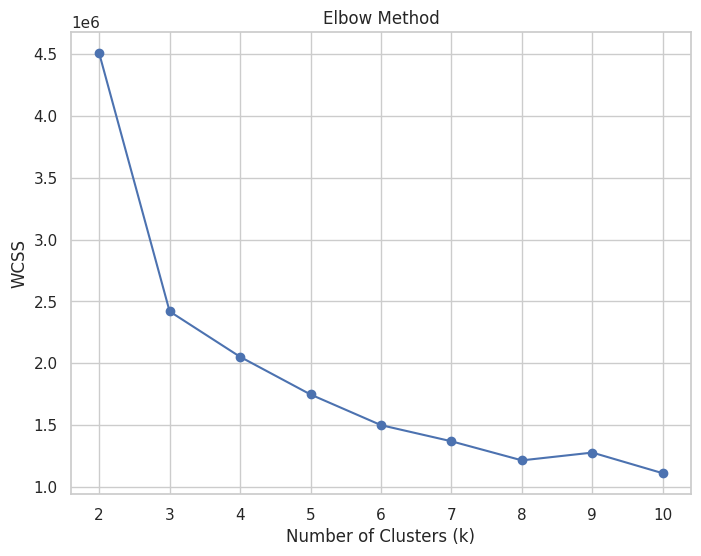

In [82]:
# create an elbow method
from pyspark.ml.clustering import KMeans
from pyspark.ml import feature
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np

wcss = []
max_k = 10

# start the loop from k=2
for k in range(2, max_k + 1):
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    model = kmeans.fit(df_log_transformed)
    # Calculate WCSS (Sum of Squared Errors)
    wcss.append(model.summary.trainingCost)

# plot elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_k + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(np.arange(2, max_k + 1, 1)) # Adjust x-ticks
plt.grid(True)
plt.show()


In [83]:
# create a k-means clustering model with k = 3
from pyspark.ml.clustering import KMeans
from pyspark.ml import feature

kmeans3 = KMeans(featuresCol='features', k=3)

df_log_transformed = va.transform(df_log)

kmeans_model3 = kmeans3.fit(df_log_transformed)

clustered_data3 = kmeans_model3.transform(df_log_transformed)

clustered_data3.select('features', 'prediction').show(10, truncate=False)

print("Cluster Centers:")
for center in kmeans_model3.clusterCenters():
    print(center)

+------------------------------------------+----------+
|features                                  |prediction|
+------------------------------------------+----------+
|[1.0,40.739944,-73.8753,1.0,3.0,1.0,0.0]  |2         |
|[0.0,40.632908,-73.92736,1.0,3.0,0.0,0.0] |2         |
|[1.0,40.757732,-73.79404,1.0,3.0,1.0,0.0] |2         |
|[0.0,40.678726,-73.91906,1.0,3.0,0.0,0.0] |2         |
|[1.0,40.758892,-73.806076,1.0,3.0,1.0,0.0]|2         |
|[0.0,40.663925,-73.89961,1.0,3.0,0.0,0.0] |2         |
|[2.0,40.75974,-73.97423,1.0,3.0,1.0,1.0]  |2         |
|[4.0,40.565235,-74.181404,1.0,3.0,0.0,0.0]|2         |
|[1.0,40.71328,-73.76606,1.0,3.0,1.0,0.0]  |2         |
|[0.0,40.664112,-73.94777,1.0,3.0,0.0,0.0] |2         |
+------------------------------------------+----------+
only showing top 10 rows

Cluster Centers:
[  1.297967    40.72441695 -73.91589001   2.8928475    8.40471899
   0.37933046   0.47001001]
[1.31141199 0.         0.         2.96034816 6.64071567 0.37959381
 0.44680851]

In [84]:
# compare original k-means with k-means3
evaluator = ClusteringEvaluator()

silhouette_original = evaluator.evaluate(clustered_data)
silhouette_k3 = evaluator.evaluate(clustered_data3)

# create a visual
print("Silhouette Score (Original K-means):", silhouette_original)
print("Silhouette Score (K-means with k=3):", silhouette_k3)

Silhouette Score (Original K-means): 0.3912478088621548
Silhouette Score (K-means with k=3): 0.5879322321302392


In [85]:
# create a k-means clustering model
from pyspark.ml.clustering import KMeans
from pyspark.ml import feature

va = feature.VectorAssembler(inputCols = ['BOROUGH_indexed', 'MODIFIED_FACTORS_indexed'],
                     outputCol = 'features')
kmeans = KMeans(featuresCol='features', k=3)

df_log_transformed = va.transform(df_log)

kmeans_model = kmeans.fit(df_log_transformed)

clustered_data = kmeans_model.transform(df_log_transformed)

clustered_data.select('features', 'prediction').show(10, truncate=False)

print("Cluster Centers:")
for center in kmeans_model.clusterCenters():
    print(center)

silhouette_reduced = evaluator.evaluate(clustered_data)

print("Silhouette Score (Reduced K-means):", silhouette_reduced)

+---------+----------+
|features |prediction|
+---------+----------+
|[1.0,0.0]|0         |
|(2,[],[])|0         |
|[1.0,0.0]|0         |
|(2,[],[])|0         |
|[1.0,0.0]|0         |
|(2,[],[])|0         |
|[2.0,1.0]|1         |
|[4.0,0.0]|1         |
|[1.0,0.0]|0         |
|(2,[],[])|0         |
+---------+----------+
only showing top 10 rows

Cluster Centers:
[0.4752705  0.14266237]
[2.63616047 0.15257124]
[1.40666225 4.05847298]
Silhouette Score (Reduced K-means): 0.7739363451211735


In [86]:
# print out the index values of BOROUGH
df_log.select('BOROUGH', 'BOROUGH_indexed').distinct().orderBy('BOROUGH_indexed').show()
df_log.select('MODIFIED_FACTORS', 'MODIFIED_FACTORS_indexed').distinct().orderBy('MODIFIED_FACTORS_indexed').show()

+-------------+---------------+
|      BOROUGH|BOROUGH_indexed|
+-------------+---------------+
|     BROOKLYN|            0.0|
|       QUEENS|            1.0|
|    MANHATTAN|            2.0|
|        BRONX|            3.0|
|STATEN ISLAND|            4.0|
+-------------+---------------+

+--------------------+------------------------+
|    MODIFIED_FACTORS|MODIFIED_FACTORS_indexed|
+--------------------+------------------------+
|     Driver Behavior|                     0.0|
|     Vehicle Defects|                     1.0|
|Traffic Control I...|                     2.0|
|   Driver Impairment|                     3.0|
|Road/Environmenta...|                     4.0|
|Pedestrian/Cyclis...|                     5.0|
|      Vehicle Status|                     6.0|
| Driver Distractions|                     7.0|
+--------------------+------------------------+



In [87]:
end_time   = time.perf_counter()

elapsed_sec = end_time - start_time
elapsed_min = elapsed_sec / 60

print(f"Elapsed time: {elapsed_min:.2f} minutes")

Elapsed time: 40.69 minutes
